# Prompt selection and testing

This notebook chooses the most appropriate prompt and prompt structure for the OCR correction. 

In [247]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai,  create_config_dict_func, use_df_to_call_llm_api
from evaluate import load
from evaluation_funcs import evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction, evaluate_ocr_dataframe, calculate_metrics
import matplotlib.pyplot as plt
from helper_functions import files_to_df_func, evaluate_ner, calculate_entity_similarity, repeat_prompt_experiment, files_to_df_core_func
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
import re
from openai import OpenAI
import itertools
import tiktoken


wer = load("wer")
cer = load("cer")
client = OpenAI()


dev_data_folder = 'data/dev_data'
dev_transcripts = os.path.join(dev_data_folder, 'dev_data_transcript')
dev_raw_ocr_folder =  os.path.join(dev_data_folder,'dev_raw_ocr' )
dev_system_message_folder = os.path.join(dev_data_folder,'dev_system_message_variants' )

#Overproof
overproof_folder = 'data/overproof'

smh_folder =  os.path.join(overproof_folder, 'SMH')
smh_articles_raw = os.path.join(smh_folder, 'line_level', 'line_raw')
smh_articles_transcribed = os.path.join(smh_folder, 'article_level', 'corrected') #in the dataset they are reffered to as corrected but this clashes with my naming convention
smh_articles_results = os.path.join(smh_folder, 'results')


# sociocultural test

socio_cultural_folder = "data/socio_cultural"

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv(os.path.join(dev_data_folder,'dev_data_raw.csv'))



#for saving data to be used in the socio cultural
if not os.path.exists(socio_cultural_folder):
    os.makedirs(socio_cultural_folder)

# Demonstrating context leveraging

The below texts can be used to demonstrate that LMs use context leveraging and that they can self-contextualise from the task itself. The words in the parenthesis are optional contxt

"""Please correct the below sentences containing OCR errors

My dog has no ***

*** did *** **** cross ***"""

In [3]:



response = get_response_openai(
    """Please correct the below sentences containing OCR errors

My dog has no ***

*** did *** **** cross ***""", 
"", RateLimiter(40000), 
engine="gpt-4-turbo-preview", 
max_tokens = 500)

2024-04-23 06:41:05 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


In [4]:

dog_nose = """My dog *** *** nose. 
How *** he ***? """

dog_nose = """My dog has no  ***"""

chicken_cross = "*** did *** **** cross ***"

chicken_cross = "why did the **** *** ***"


prompt_dog =f"""Please correct the below sentences containing OCR errors

{dog_nose}

"""

prompt_dog_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke

{dog_nose}

"""

check_prompt_dog = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'my dog has no nose', Answer 1 or 0
:::
{answer}
:::

"""

prompt_chicken =f"""Please correct the below sentences containing OCR errors

{chicken_cross}

"""

prompt_chicken_joke =f"""Please correct the below sentences containing OCR errors, the sentence is part of a popular joke

{chicken_cross}

"""

check_prompt_chicken = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify the sentence 'why did the chicken cross the road', Answer 1 or 0
:::
{answer}
:::

"""


prompt_combined =f"""Please correct the below sentences containing OCR errors

{dog_nose}

{chicken_cross}
"""

prompt_combined_joke =f"""Please correct the below sentences containing OCR errors, the sentences are part of a popular jokes

{dog_nose}

{chicken_cross}
"""

check_combined = """The below text surrounded by triple colons is the response of a language model to a task, did it correctly identify both the sentences 'my dog has no nose' and 'why did the chicken cross the road', Answer 1 if both identified or 0 otherwise
:::
{answer}
:::

"""


In [5]:
context_check = pd.DataFrame([
             {'prompt': prompt_dog, 'check':check_prompt_dog, 'context':'no', 'joke':'dog' },
             {'prompt': prompt_dog_joke, 'check':check_prompt_dog, 'context':'yes', 'joke':'dog' },
             {'prompt': prompt_chicken, 'check':check_prompt_chicken, 'context':'no', 'joke':'chicken' },
             {'prompt': prompt_chicken_joke, 'check':check_prompt_chicken, 'context':'yes', 'joke':'chicken' },
             {'prompt': prompt_combined, 'check':check_combined, 'context':'no', 'joke':'combined' },
             {'prompt': prompt_combined_joke, 'check':check_combined, 'context':'yes', 'joke':'combined' }
            ])


context_results =[]
for index, row in context_check.iterrows():

    result = repeat_prompt_experiment(row['prompt'] , row['check'] , client, repititions = 100)

    result['context'] = row['context']
    result['joke'] = row['joke']

    context_results.append(result)


context_results = pd.concat(context_results, ignore_index=True)

#context_results.to_csv("does_LM_use_context_results.csv")

2024-04-23 06:41:06 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:06 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:08 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:09 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:10 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 06:41:10 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


KeyboardInterrupt: 

# Spoofing and **T**ask **I**nduced **I**n **C**ontext **L**earning

This section performs the test of how the amount of text and the prompt given interact.

In [90]:
def combine_rows_func(dataframe, group_column, content_column, x):
    # Assign group indices within each id group
    dataframe['group_index'] = dataframe.groupby(group_column).cumcount() // x
    
    # Group by id and the new group_index
    grouped = dataframe.groupby([group_column, 'group_index'])

    # Filter groups that do not have exactly 'x' items
    valid_groups = grouped.filter(lambda g: len(g) == x)

    # Concatenate content within the valid groups
    result_df = valid_groups.groupby([group_column, 'group_index'])[content_column].agg(' '.join).reset_index()
    
    # Calculate the start and end row numbers for each group
    result_df['start_row'] = result_df.groupby(group_column).cumcount() * x + 1
    result_df['end_row'] = result_df['start_row'] + x - 1

    result_df['file_name'] = result_df['id'] + "_lines" + "_" + result_df['start_row'].astype(str) + "_" + result_df['end_row'].astype(str) + ".txt" 
    
    # Drop the group_index as it is no longer needed
    result_df.drop('group_index', axis=1, inplace=True)
    
    return result_df

In [71]:
prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."""
context_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Sydney Morning Herald 1842 -1950. """
spoof_prompt_smh = "{content}"+f""" \n \n """ + f"""You are an expert in post-OCR correction of documents. Using the context available from the text please recover the most likely original text from the corrupted OCR. Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions. The text is from The Hong Kong Restaurant Review 1989-1993. """




In [31]:
enc = tiktoken.encoding_for_model("gpt-3.5-turbo") 

In [296]:
raw_lines_ocr_df = files_to_df_core_func(smh_articles_raw).sort_values('file_name')
raw_lines_ocr_df['line'] = raw_lines_ocr_df['file_name'].str.split("_line").str.get(1).str.replace(".txt", "").astype(int)
raw_lines_ocr_df['id'] = raw_lines_ocr_df['file_name'].str.split("_line").str.get(0)
raw_lines_ocr_df['total_tokens'] = raw_lines_ocr_df['content'].apply(lambda x: len(enc.encode(x)))

#we want to keep only ids with at least 50 rows
max_group_size = 50

total_dataset_df = combine_rows_func(raw_lines_ocr_df, 'id', 'content', max_group_size)
total_dataset_df['total_tokens'] = total_dataset_df['content'].apply(lambda x: len(enc.encode(x)))
total_dataset_df = total_dataset_df.loc[total_dataset_df['end_row']<=max_group_size]

#subset only to the test data
raw_lines_ocr_df = raw_lines_ocr_df.loc[raw_lines_ocr_df['id'].isin(total_dataset_df['id'].unique()),:].reset_index()


In [297]:
raw_lines_ocr_df

,index,file_name,content,line,id,total_tokens,group_index
0,7697,12878000_year_1845_type_Article_title_The_Sydn...,LAND SALE.,1,12878000_year_1845_type_Article_title_The_Sydn...,3,0
1,28,12878000_year_1845_type_Article_title_The_Sydn...,"each, allotments Nos. 3 and 4 of section 13. 3.",10,12878000_year_1845_type_Article_title_The_Sydn...,19,0
2,1918,12878000_year_1845_type_Article_title_The_Sydn...,"34$ perches, No. 5 of section 13. 4.34| perches,",11,12878000_year_1845_type_Article_title_The_Sydn...,22,0
3,870,12878000_year_1845_type_Article_title_The_Sydn...,"No. 6 of section 13. 5. 33\ perches, No. 7 of",12,12878000_year_1845_type_Article_title_The_Sydn...,23,0
4,959,12878000_year_1845_type_Article_title_The_Sydn...,"section 13. 6. 341 perches, No. 8 of section",13,12878000_year_1845_type_Article_title_The_Sydn...,18,0
...,...,...,...,...,...,...,...
4879,4840,29764000_year_1946_type_Article_title_The_Sydn...,"of pleurisy, is fn bed again, and it s",95,29764000_year_1946_type_Article_title_The_Sydn...,13,2
4880,5647,29764000_year_1946_type_Article_title_The_Sydn...,"unlikely that he, will play again ia",96,29764000_year_1946_type_Article_title_The_Sydn...,8,2
4881,5338,29764000_year_1946_type_Article_title_The_Sydn...,Australia.,97,29764000_year_1946_type_Article_title_The_Sydn...,2,2
4882,2279,29764000_year_1946_type_Article_title_The_Sydn...,Mr. Popplewell announced the fol-,98,29764000_year_1946_type_Article_title_The_Sydn...,9,2


In [104]:
prompt_dict = {'prompt':[prompt_smh, context_prompt_smh, spoof_prompt_smh],
 'response_name':['basic', 'context', 'spoof']
 }


socio_list = [
    create_config_dict_func(
        get_response_func=get_response_openai,
        rate_limiter=RateLimiter(160e3),
        engine='gpt-3.5-turbo',
        system_message_template="",
        prompt_template=prompt_dict['prompt'][num],
        additional_args={"response_name": prompt_dict['response_name'][num]} ## will be added to in the loop
    )
    for num in  [0,1,2]
]


In [111]:
number_lines_list = [1, 10, 20, 30, 40, 50]

for config, group_size in itertools.product(socio_list, number_lines_list ):

    temporary_df = combine_rows_func(raw_lines_ocr_df, 'id', 'content', group_size)

    temporary_df['id'] = temporary_df['file_name']

    response_name = config['response_name'] + "_" + str(group_size)

    use_df_to_call_llm_api(config, temporary_df, response_name , folder_path= os.path.join(socio_cultural_folder ))

2024-04-23 15:31:02 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:05 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:08 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:12 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:17 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:20 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:24 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:29 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-04-23 15:31:33 httpx INFO: HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 

KeyboardInterrupt: 

In [115]:
corrected_ocr_line = files_to_df_core_func(smh_articles_transcribed).sort_values('file_name')
corrected_ocr_line['line'] = corrected_ocr_line['file_name'].str.split("_line").str.get(1).str.replace(".txt", "").astype(int)
corrected_ocr_line['id'] = corrected_ocr_line['file_name'].str.split("_line").str.get(0)
corrected_ocr_line['total_tokens'] = corrected_ocr_line['content'].apply(lambda x: len(enc.encode(x)))

#we want to keep only ids with at least 50 rows
max_group_size = 50

total_dataset_corrected_df = combine_rows_func(corrected_ocr_line, 'id', 'content', max_group_size)
total_dataset_corrected_df['total_tokens'] = total_dataset_corrected_df['content'].apply(lambda x: len(enc.encode(x)))
total_dataset_corrected_df = total_dataset_corrected_df.loc[total_dataset_corrected_df['end_row']<=max_group_size]

#subset only to the test data
corrected_ocr_line = corrected_ocr_line.loc[corrected_ocr_line['id'].isin(total_dataset_df['id'].unique()),:].reset_index()

In [108]:
corrected_ocr_line 

,index,file_name,content,line,id,total_tokens,group_index
0,7697,12878000_year_1845_type_Article_title_The_Sydn...,LAND SALE.,1,12878000_year_1845_type_Article_title_The_Sydn...,3,0
1,28,12878000_year_1845_type_Article_title_The_Sydn...,"each, allotments Nos. 3 and 4 of section 13. 3.",10,12878000_year_1845_type_Article_title_The_Sydn...,19,0
2,1918,12878000_year_1845_type_Article_title_The_Sydn...,"34$ perches, No. 5 of section 13. 4.34| perches,",11,12878000_year_1845_type_Article_title_The_Sydn...,22,0
3,870,12878000_year_1845_type_Article_title_The_Sydn...,"No. 6 of section 13. 5. 33\ perches, No. 7 of",12,12878000_year_1845_type_Article_title_The_Sydn...,23,0
4,959,12878000_year_1845_type_Article_title_The_Sydn...,"section 13. 6. 341 perches, No. 8 of section",13,12878000_year_1845_type_Article_title_The_Sydn...,18,0
...,...,...,...,...,...,...,...
4879,4840,29764000_year_1946_type_Article_title_The_Sydn...,"of pleurisy, is fn bed again, and it s",95,29764000_year_1946_type_Article_title_The_Sydn...,13,2
4880,5647,29764000_year_1946_type_Article_title_The_Sydn...,"unlikely that he, will play again ia",96,29764000_year_1946_type_Article_title_The_Sydn...,8,2
4881,5338,29764000_year_1946_type_Article_title_The_Sydn...,Australia.,97,29764000_year_1946_type_Article_title_The_Sydn...,2,2
4882,2279,29764000_year_1946_type_Article_title_The_Sydn...,Mr. Popplewell announced the fol-,98,29764000_year_1946_type_Article_title_The_Sydn...,9,2


In [125]:
temporary_df 

,id,content,start_row,end_row,file_name
0,12878000_year_1845_type_Article_title_The_Sydn...,"LAND SALE. each, allotments Nos. 3 and 4 of se...",1,50,12878000_year_1845_type_Article_title_The_Sydn...
1,12918000_year_1850_type_Article_title_The_Sydn...,BERRIMA. mination. ELECTORAL LIST For 1850-1. ...,1,50,12918000_year_1850_type_Article_title_The_Sydn...
2,12979000_year_1856_type_Article_title_The_Sydn...,MORETON BAY. for belief that the branch of the...,1,50,12979000_year_1856_type_Article_title_The_Sydn...
3,12979000_year_1856_type_Article_title_The_Sydn...,"first wheel the stones in, in the rough state,...",51,100,12979000_year_1856_type_Article_title_The_Sydn...
4,13005000_year_1858_type_Article_title_The_Sydn...,MUNICIPAL COUNCIL open and determine on the un...,1,50,13005000_year_1858_type_Article_title_The_Sydn...
...,...,...,...,...,...
71,28077000_year_1923_type_Article_title_The_Sydn...,QUARTER SESSIONS. Honor varied the sentence to...,1,50,28077000_year_1923_type_Article_title_The_Sydn...
72,28077000_year_1923_type_Article_title_The_Sydn...,"on June 30, at Sydney, falsely pretended to Ch...",51,100,28077000_year_1923_type_Article_title_The_Sydn...
73,28256000_year_1895_type_Article_title_The_Sydn...,"CLEARANCES. - May 7 Rotokino (s.), 2004 tons, ...",1,50,28256000_year_1895_type_Article_title_The_Sydn...
74,29764000_year_1946_type_Article_title_The_Sydn...,ENGLAND DEFERS It is doubtful if Harry Murphy ...,1,50,29764000_year_1946_type_Article_title_The_Sydn...


In [214]:
lm_corrected_temp = files_to_df_core_func(os.path.join(socio_cultural_folder, 'context_10_gpt-3.5-turbo'))
lm_corrected_temp = lm_corrected_temp.groupby(lm_corrected_temp['file_name'].str.split('_lines_').str[0])['content'].apply(' '.join).reset_index()

#merge together
temp = temporary_transcribed_df.merge(lm_corrected_temp, left_on='id', right_on = 'file_name', suffixes=['_transcr', '_lm'])

temp

,index,file_name_transcr,content_transcr,line,id,total_tokens,group_index,file_name_lm,content_lm
0,7697,12878000_year_1845_type_Article_title_The_Sydn...,LAND SALE.,1,12878000_year_1845_type_Article_title_The_Sydn...,3,0,12878000_year_1845_type_Article_title_The_Sydn...,"portion 1. 9. 10 acres, same place, No. 2 of p..."
1,28,12878000_year_1845_type_Article_title_The_Sydn...,"each, allotments Nos. 3 and 4 of section 13. 3.",10,12878000_year_1845_type_Article_title_The_Sydn...,19,0,12878000_year_1845_type_Article_title_The_Sydn...,"portion 1. 9. 10 acres, same place, No. 2 of p..."
2,1918,12878000_year_1845_type_Article_title_The_Sydn...,"34½ perches, No. 5 of section 13. 4. 34¼ perches,",11,12878000_year_1845_type_Article_title_The_Sydn...,23,0,12878000_year_1845_type_Article_title_The_Sydn...,"portion 1. 9. 10 acres, same place, No. 2 of p..."
3,870,12878000_year_1845_type_Article_title_The_Sydn...,"No. 6 of section 13. 5. 33¼ perches, No. 7 of",12,12878000_year_1845_type_Article_title_The_Sydn...,23,0,12878000_year_1845_type_Article_title_The_Sydn...,"portion 1. 9. 10 acres, same place, No. 2 of p..."
4,959,12878000_year_1845_type_Article_title_The_Sydn...,"section 13. 6. 34½ perches, No. 8 of section",13,12878000_year_1845_type_Article_title_The_Sydn...,19,0,12878000_year_1845_type_Article_title_The_Sydn...,"portion 1. 9. 10 acres, same place, No. 2 of p..."
...,...,...,...,...,...,...,...,...,...
4879,4840,29764000_year_1946_type_Article_title_The_Sydn...,"of pleurisy, is in bed again, and it is",95,29764000_year_1946_type_Article_title_The_Sydn...,13,2,29764000_year_1946_type_Article_title_The_Sydn...,in Brisbane. His tackling and long kicking wer...
4880,5647,29764000_year_1946_type_Article_title_The_Sydn...,"unlikely that he, will play again in",96,29764000_year_1946_type_Article_title_The_Sydn...,8,2,29764000_year_1946_type_Article_title_The_Sydn...,in Brisbane. His tackling and long kicking wer...
4881,5338,29764000_year_1946_type_Article_title_The_Sydn...,Australia.,97,29764000_year_1946_type_Article_title_The_Sydn...,2,2,29764000_year_1946_type_Article_title_The_Sydn...,in Brisbane. His tackling and long kicking wer...
4882,2279,29764000_year_1946_type_Article_title_The_Sydn...,Mr. Popplewell announced the fol-,98,29764000_year_1946_type_Article_title_The_Sydn...,9,2,29764000_year_1946_type_Article_title_The_Sydn...,in Brisbane. His tackling and long kicking wer...


In [253]:
temporary_transcribed_df = files_to_df_core_func(smh_articles_transcribed) #

temporary_transcribed_df['id'] = temporary_transcribed_df['file_name'].str.replace('.txt', "")

temporary_transcribed_df.drop(columns='file_name', inplace=True)

temporary_transcribed_df

,content,id
0,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...
1,"ENTHUSIASTIC MEETING AT IPSWICH.\nBRISBANE, Th...",14219000_year_1899_type_Article_title_The_Sydn...
2,PUBLIC LIBRARIAN.\n-»-\nOFFER TO MR. IFOULD.\n...,15344000_year_1912_type_Article_title_The_Sydn...
3,"MR. D. RYRIE, M.L.A., AT BOMBALA.\n[BY TELEGRA...",28366000_year_1885_type_Article_title_The_Sydn...
4,A GOLD-BEARING REEF.\nDISCOVERED AT EUCHAREENA...,14656000_year_1904_type_Article_title_The_Sydn...
...,...,...
154,EARTHQUAKE NEAR\nALICE SPRINGS.\nRECORDED IN S...,27945000_year_1941_type_Article_title_The_Sydn...
155,MR. ALEXANDER VEITCH.\nMany of the bowlers and...,16443000_year_1928_type_Article_title_The_Sydn...
156,"Magistrate\nBars\nMr. Evatt\n--\nMr Beavers, S...",18235000_year_1951_type_Article_title_The_Sydn...
157,SHIPPING INTELLIGENCE.\nARRIVALS.\nOCTOBER 4.-...,12931000_year_1851_type_Article_title_The_Sydn...


In [254]:
pattern = r'_(\d+)_'

performance_vs_lines = []

#temporary_transcribed_df = combine_rows_func(corrected_ocr_line, 'id', 'content', 50)

temporary_transcribed_df = files_to_df_core_func(smh_articles_transcribed) #
temporary_transcribed_df['content'] = temporary_transcribed_df['content'].str.replace("-\n", "").str.replace("\n", " ")

temporary_transcribed_df['id'] = temporary_transcribed_df['file_name'].str.replace('.txt', "")

temporary_transcribed_df.drop(columns='file_name', inplace=True)

for folder in os.listdir(socio_cultural_folder):
    agg_num =  int(re.search(pattern, folder).group(1))
    print(f"folder:{folder}, lines agg:{agg_num}")
    #aggregate to the same level as the LM version
    #if agg_num == 1:
        #temporary_transcribed_df = corrected_ocr_line
    #    continue
    #else:
    #    temporary_transcribed_df = combine_rows_func(corrected_ocr_line, 'id', 'content', agg_num)

    #load the version corrected by the lm

    lm_corrected_temp = files_to_df_core_func(os.path.join(socio_cultural_folder, folder))

    lm_corrected_temp['id'] = lm_corrected_temp['file_name'].str.extract(r'(.+)_lines_')[0]
    lm_corrected_temp['order'] = lm_corrected_temp['file_name'].str.extract(r'_lines_(\d+)')[0].astype(int)

    # Group by the grouping key and aggregate the content based on the order
    result_df = lm_corrected_temp.groupby('id')[['order', 'content']].apply(lambda x: ' '.join(x.sort_values('order')['content']))

    # Reset the index to get the grouping key as a regular column
    #result_df = lm_corrected_temp.reset_index(name='content')

    #merge together
    temp = temporary_transcribed_df.merge(lm_corrected_temp, left_on='id', right_on = 'id', suffixes=['_transcr', '_lm'])

    test = pd.concat([calculate_metrics(row['id'], row['content_lm'].lower(), row['content_transcr'].lower(), wer, cer) for _, row in temp.iterrows()]).drop(columns='File Name')

    result_df = test.agg(['mean', 'median'])

    result_df['average'] = ['mean', 'median']

    result_df['lines'] = agg_num

    result_df['type'] = folder

    performance_vs_lines.append(result_df)

performance_vs_lines = pd.concat(performance_vs_lines, ignore_index=True)

performance_vs_lines['type'] =  performance_vs_lines['type'].str.split("_").str.get(0)

folder:context_40_gpt-3.5-turbo, lines agg:40
folder:basic_10_gpt-3.5-turbo, lines agg:10
folder:basic_20_gpt-3.5-turbo, lines agg:20
folder:context_30_gpt-3.5-turbo, lines agg:30
folder:basic_30_gpt-3.5-turbo, lines agg:30
folder:spoof_30_gpt-3.5-turbo, lines agg:30
folder:spoof_20_gpt-3.5-turbo, lines agg:20
folder:context_1_gpt-3.5-turbo, lines agg:1
folder:context_10_gpt-3.5-turbo, lines agg:10
folder:context_20_gpt-3.5-turbo, lines agg:20
folder:basic_50_gpt-3.5-turbo, lines agg:50
folder:basic_1_gpt-3.5-turbo, lines agg:1
folder:basic_40_gpt-3.5-turbo, lines agg:40
folder:context_50_gpt-3.5-turbo, lines agg:50
folder:spoof_1_gpt-3.5-turbo, lines agg:1
folder:spoof_10_gpt-3.5-turbo, lines agg:10


In [293]:
ocr_raw_temp = files_to_df_core_func("data/overproof/SMH/line_level/line_raw")

ocr_raw_temp['id'] = ocr_raw_temp['file_name'].str.extract(r'(.+)_line')[0]
ocr_raw_temp['order'] = ocr_raw_temp['file_name'].str.extract(r'_line(\d+)')[0].astype(int)

# Group by the grouping key and aggregate the content based on the order
result_df_raw = ocr_raw_temp.groupby('id')[['order', 'content']].apply(lambda x: ' '.join(x.sort_values('order')['content']))

In [300]:
temp = combine_rows_func(test, 'id', 'content', 10)

temp.loc[temp['id']=='16856000_year_1932_type_Article_title_The_Sydney_Morn_aid_16856000']

,id,content,start_row,end_row,file_name
273,16856000_year_1932_type_Article_title_The_Sydn...,FOOTBALL. the season especially as the New Zea...,1,10,16856000_year_1932_type_Article_title_The_Sydn...
274,16856000_year_1932_type_Article_title_The_Sydn...,and it Is llkolv that most Interest will be ta...,11,20,16856000_year_1932_type_Article_title_The_Sydn...
275,16856000_year_1932_type_Article_title_The_Sydn...,a (¡rent deal of worry Manly will be Immeasur-...,21,30,16856000_year_1932_type_Article_title_The_Sydn...
276,16856000_year_1932_type_Article_title_The_Sydn...,Biy Eastern Suburbs has a splendid mixture of ...,31,40,16856000_year_1932_type_Article_title_The_Sydn...
277,16856000_year_1932_type_Article_title_The_Sydn...,University Is one team which will enter the fi...,41,50,16856000_year_1932_type_Article_title_The_Sydn...
278,16856000_year_1932_type_Article_title_The_Sydn...,sufficiently healed will play at live eighth H...,51,60,16856000_year_1932_type_Article_title_The_Sydn...


In [294]:
ocr_raw_temp.loc[ocr_raw_temp['id']=='16856000_year_1932_type_Article_title_The_Sydney_Morn_aid_16856000'].sort_values('order')

,file_name,content,id,order
1346,16856000_year_1932_type_Article_title_The_Sydn...,FOOTBALL.,16856000_year_1932_type_Article_title_The_Sydn...,1
3451,16856000_year_1932_type_Article_title_The_Sydn...,RUGBY UNION.,16856000_year_1932_type_Article_title_The_Sydn...,2
4615,16856000_year_1932_type_Article_title_The_Sydn...,Premiership Opening.,16856000_year_1932_type_Article_title_The_Sydn...,3
2680,16856000_year_1932_type_Article_title_The_Sydn...,MANLY MEETS RANDWICK.,16856000_year_1932_type_Article_title_The_Sydn...,4
887,16856000_year_1932_type_Article_title_The_Sydn...,After sever»! rounds of unofflclnl triol matches,16856000_year_1932_type_Article_title_The_Sydn...,5
...,...,...,...,...
1442,16856000_year_1932_type_Article_title_The_Sydn...,moyne fifteen Among those making a debut In,16856000_year_1932_type_Article_title_The_Sydn...,65
5597,16856000_year_1932_type_Article_title_The_Sydn...,senior football will be last year s star St Jo...,16856000_year_1932_type_Article_title_The_Sydn...,66
2111,16856000_year_1932_type_Article_title_The_Sydn...,College and Great Public Schools wing three,16856000_year_1932_type_Article_title_The_Sydn...,67
5389,16856000_year_1932_type_Article_title_The_Sydn...,quarter J Kelaher who Is with Drummoyne,16856000_year_1932_type_Article_title_The_Sydn...,68


In [273]:
lm_corrected_temp.loc[lm_corrected_temp['id']=='16856000_year_1932_type_Article_title_The_Sydney_Morn_aid_16856000'].sort_values('order')

,file_name,content,id,order
433,16856000_year_1932_type_Article_title_The_Sydn...,"Football, the season especially as the New Zea...",16856000_year_1932_type_Article_title_The_Sydn...,1
25,16856000_year_1932_type_Article_title_The_Sydn...,It is likely that most interest will be taken ...,16856000_year_1932_type_Article_title_The_Sydn...,11
267,16856000_year_1932_type_Article_title_The_Sydn...,A great deal of worry Manly will be immeasurab...,16856000_year_1932_type_Article_title_The_Sydn...,21
151,16856000_year_1932_type_Article_title_The_Sydn...,Eastern Suburbs has a splendid mixture of expe...,16856000_year_1932_type_Article_title_The_Sydn...,31
431,16856000_year_1932_type_Article_title_The_Sydn...,University is one team which will enter the fi...,16856000_year_1932_type_Article_title_The_Sydn...,41
248,16856000_year_1932_type_Article_title_The_Sydn...,"Sufficiently healed, Will Play at Live Eighth ...",16856000_year_1932_type_Article_title_The_Sydn...,51


In [271]:
temp.loc[temp['id']=='16856000_year_1932_type_Article_title_The_Sydney_Morn_aid_16856000'].sort_values('order')#['id'][0]#['content_transcr'][0]

,content_transcr,id,file_name,content_lm,order
5,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,"Football, the season especially as the New Zea...",1
0,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,It is likely that most interest will be taken ...,11
3,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,A great deal of worry Manly will be immeasurab...,21
1,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,Eastern Suburbs has a splendid mixture of expe...,31
4,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,University is one team which will enter the fi...,41
2,FOOTBALL.\nRUGBY UNION.\nPremiership Opening.\...,16856000_year_1932_type_Article_title_The_Sydn...,16856000_year_1932_type_Article_title_The_Sydn...,"Sufficiently healed, Will Play at Live Eighth ...",51


In [264]:
temp['id'][0]

'16856000_year_1932_type_Article_title_The_Sydney_Morn_aid_16856000'

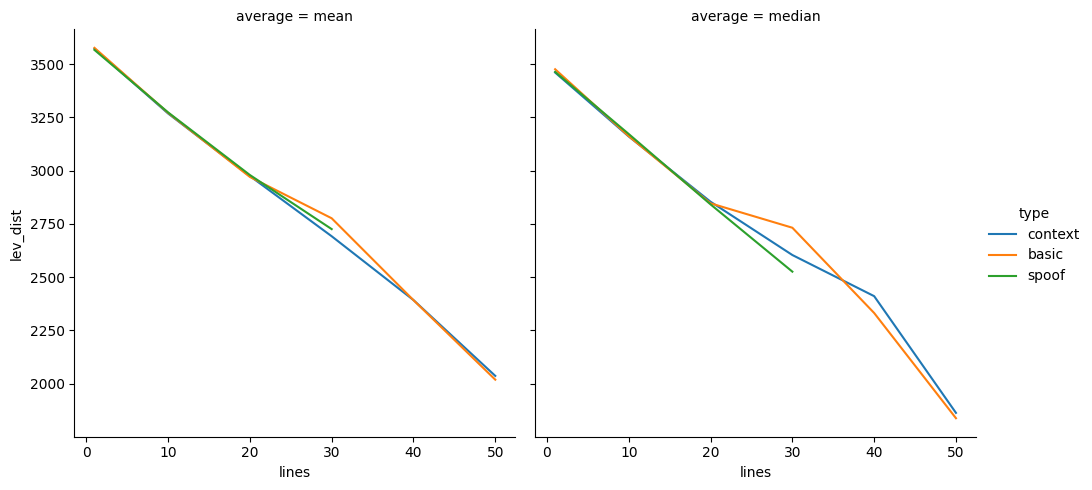

In [265]:
sns.relplot(data=performance_vs_lines, x='lines', y='lev_dist', hue='type', col='average', kind='line')
plt.show()

In [183]:
folder = 'context_1_gpt-3.5-turbo'

print(folder)
agg_num =  int(re.search(pattern, folder).group(1))

#aggregate to the same level as the LM version
if agg_num == 1:
    temporary_transcribed_df = corrected_ocr_line
    continue
else:
    temporary_transcribed_df = combine_rows_func(corrected_ocr_line, 'id', 'content', agg_num)

#load the version corrected by the lm
lm_corrected_temp = files_to_df_core_func(os.path.join(socio_cultural_folder, folder))

#merge together
temp = temporary_transcribed_df.merge(lm_corrected_temp, on = 'file_name', suffixes=['_transcr', '_lm'])

test = pd.concat([calculate_metrics(row['file_name'], row['content_lm'].lower(), row['content_transcr'].lower(), wer, cer) for _, row in temp.iterrows()]).drop(columns='File Name')

result_df = test.agg(['mean', 'median'])

result_df['lines'] = agg_num

result_df['type'] = folder

performance_vs_lines.append(result_df)


context_1_gpt-3.5-turbo


SyntaxError: 'continue' not properly in loop (2066944641.py, line 9)